# Compute missing heritability in simulated sampling
With 1D simulations

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.style.use("seaborn")
%matplotlib inline

## Make df to access simulations

In [9]:
# 2D sims
# label = "082219"

# 1D sims
label = '021820'

filenames = glob.glob(('../../../data/output/*%s*')%(label))
print("Number of simulations: ", len(filenames))

Number of simulations:  18


In [13]:
df = pd.DataFrame(columns=['filename','pop_size','mu','s','m'],
                  data={'filename':filenames})

In [14]:
def filename_parser(filename,params):
    return [float(filename.split(("_%s_")%(i))[1].split("_")[0]) for i in params]

In [15]:
for i in range(df.shape[0]):
    df.iloc[i,1:] = filename_parser(df.iloc[i,0],df.columns[1:]) 

In [16]:
### Make new columns for important summary stats
df['N*mu']= df['pop_size']*df['mu']
df['N*s']= df['pop_size']*df['s']
df['mu/s']= df['mu']/(df['s'] + np.finfo(float).eps)
df['dc']= (df['m']/(df['s']+np.finfo(float).eps))**(1/2)

In [17]:
df.sort_values(by=['N*mu','N*s','mu/s','dc']).head()

,filename,pop_size,mu,s,m,N*mu,N*s,mu/s,dc
9,../../data/output/SS_WF_freqs_pop_size_100000....,100000,0,0.001,0.001,0,100,0,1
15,../../data/output/SS_WF_freqs_pop_size_100000....,100000,0,0.001,0.01,0,100,0,3.16228
17,../../data/output/SS_WF_freqs_pop_size_100000....,100000,0,0.001,0.1,0,100,0,10
2,../../data/output/SS_WF_freqs_pop_size_100000....,100000,0,0.01,0.001,0,1000,0,0.316228
1,../../data/output/SS_WF_freqs_pop_size_1000000...,1e+06,0,0.001,0.001,0,1000,0,1


## Apply sampling filter

In [18]:
from scipy.ndimage import gaussian_filter

In [19]:
def sample_f(f,sigma):
    F = np.zeros(f.shape)
    ## Need to convolve array along spatial axes
    ## so iterate over time axis
    for i in range(f.shape[0]):
        F[i] = gaussian_filter(f[i],sigma=sigma,mode = "wrap")
    return F

## Compute missing heritability in selected simulations

In [193]:
def compute_H_var(f, focal_x_pos = 0, 
                  focal_y_pos = 0, 
                  sigma = 1, n = 100):
    # underlying frequency at focal deme position 
    focal_f = f[:,focal_x_pos,focal_y_pos]
    # sample from f with gaussian filter
    F = sample_f(f,sigma)
    # Compute sampling probability with sample size n
    P_samp = 1-F**n - (1-F)**n 
    # Move focal deme location to idx[0,0] corner of sampling map
    P_samp = np.roll(P_samp, (-focal_x_pos,-focal_y_pos), axis=(1,2))
    # Missing heritability calculation 
    exp_var = 0 # expected_variance in focal deme
    H = 0 # Heritability
    # Sum over replicates 
    for i in range(f.shape[0]):
        H += (focal_f[i]*(1-focal_f[i])*P_samp[i])
        exp_var += (focal_f[i])*(1-focal_f[i])
    # fraction of focal deme variance captured in sampling
    H_var = H / exp_var
    
    return H_var

### Choose simulations to compute H_var

In [21]:
test_sims= pd.DataFrame.reset_index(df[(df['dc'] > 9) & (df['dc'] < 11) & \
                (df['N*mu']<1) & (df['N*s'] >= 1) & (df['pop_size'] > 100)],drop=True)
test_sims

,filename,pop_size,mu,s,m,N*mu,N*s,mu/s,dc
0,../../data/output/SS_WF_freqs_pop_size_1000000...,1e+06,0,0.001,0.1,0,1000,0,10
1,../../data/output/SS_WF_freqs_pop_size_100000....,100000,0,0.001,0.1,0,100,0,10


In [22]:
my_f = test_sims.iloc[1] 
f = np.load(my_f.filename)
f.shape

(1000, 50, 1)

### Compute H over a range of focal demes


In [237]:
n = 100
L = f.shape[1]

sig_list = np.arange(L)

focal_x_pos = np.arange(L)
focal_y_pos = 0

demes = np.arange(L)

H_var_arr = np.zeros(tuple([len(focal_x_pos)])+f.shape[1:])
centered_H_arr = np.zeros(tuple([len(sig_list)]) + f.shape[1:])

for s, sigma in enumerate(sig_list):
    for i, pos in enumerate(focal_x_pos):
        H_var_arr[i] = compute_H_var(f, focal_x_pos = pos, 
                              focal_y_pos = focal_y_pos,
                             sigma = sigma, n = n)

    centered_H_arr[s] = np.roll(np.mean(H_var_arr,axis=0),L//2)
    

### Plot of Heritability vs. distance from focal deme


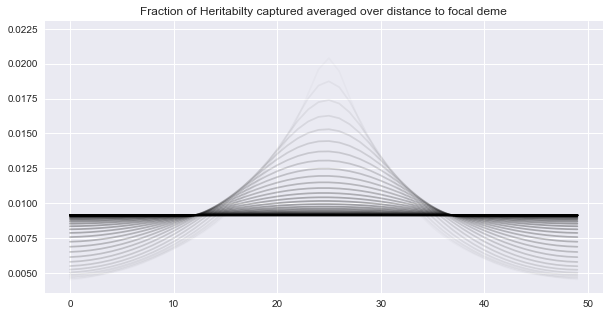

In [240]:
sig_list = np.arange(centered_H_arr.shape[0])

fig, ax = plt.subplots(1, figsize= (10,5))

for s, sigma in enumerate(sig_list):
    centered_H = centered_H_arr[s]

    ax.plot(centered_H,alpha = (sigma)/len(sig_list), 
            color = "black")

ax.set_title("Fraction of Heritabilty captured averaged over distance to focal deme")

plt.show()


In [5]:
x = np.load("../../../doc/test_results/missing_heritability/H_var_centered_pop_size_100000.0_mu_0_s_0.001_m_0.1_label_021820.npy")
x.shape

(50, 50, 1)